In [34]:
import os
import mne
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs

from helper_functions import save_figure

In [2]:
with open('../settings.json', "r") as f:
    settings = json.load(f)
    
epoch_folder = settings['epochs_folder']
plot_folder = settings['plots_folder']

In [223]:
bad_chans = {
    "80630": ["OFC_R"],
    "80625": ["OFC_L"],
    "81193": ["OFC_R", "OFC_L"]
}

In [21]:
freq_bands = {'Delta': (2, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30), 'Gamma': (30, 100)}

Import the epoch file and drop unwanted EMG channels

In [4]:
filtered_epochs = mne.read_epochs(os.path.join(epoch_folder, "filtered_epochs_w_movement-epo.fif"), preload=True)
filtered_epochs.drop_channels(['EMG_L', 'EMG_R'])

Number of events,21980
Events,1: 21980
Time range,0.000 – 4.999 s
Baseline,off


We want to investigate differences between resting and non-resting, so let's split the epochs on this behaviour using the metadata

In [6]:
movement_epochs = filtered_epochs[filtered_epochs.metadata["movement"] == 1]
non_movement_epochs = filtered_epochs[filtered_epochs.metadata["movement"] == 0]

### General fucntions

Let's create a function that takes a connectivity measure method as an argument and computes it

In [7]:
def compute_con(epochs, method, fmin=0, fmax=100):
    # Compute spectral connectivity
    con= spectral_connectivity_epochs(
        epochs, method=method, mode='multitaper', sfreq=epochs.info['sfreq'],
        fmin=fmin, fmax=fmax, faverage=True, verbose=False, gc_n_lags=40)
    return con.get_data(output='dense')

And now a general function that allows us to generate a connectivity measure dataframe for a given measure. Note that we omit the channel-channel connectivity measures for the 'low qaulity' channels that are manually entered into the *bad_chans* dictionary defined above.

In [230]:
def connectivity_df(epochs, method):
    results_df = pd.DataFrame()
    subject_ids = epochs.metadata['animal_id'].unique()

    # per subject, calculate the given measure for all epochs
    for idx, subject_id in enumerate(subject_ids):
        # subset of the data for this subject
        mouse_epochs = epochs[epochs.metadata['animal_id']==subject_id].copy()
        genotype = mouse_epochs.metadata['genotype'].unique()[0]
    
        # compute the given connectivity measure for every frequency band
        for band_name, (fmin, fmax) in freq_bands.items():
            # compute the connectivity using the provided method
            con = compute_con(mouse_epochs, method, fmin, fmax)
            
            # loop through first channel of connectivity pair
            for i in range(con.shape[1]):
                # loop through second channel of connectivity pair
                for j in range(i+1, con.shape[0]):
                    # if looped channel for this subject in bad channel dict, skip it
                    if subject_id in bad_chans.keys():
                        if epochs.ch_names[i] in bad_chans[subject_id] or epochs.ch_names[j] in bad_chans[subject_id]:
                            continue
                    # add the data
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'con' : con[j, i, 0],
                        'node1' : epochs.ch_names[i],
                        'node2' : epochs.ch_names[j],
                        'band' : band_name,
                        'subject_id': subject_id,
                        'genotype': genotype
                    }, index=[0])], ignore_index=True)
                    
    return results_df

And a function which allows us to generate neat heatmaps of a given connectivity measure

In [46]:
def generate_con_heatmap(df, freq_band, cmap, fig_title='', method='', ax=None):
    # subset the data for a given frequency band
    filtered_df = df[df['band'] == freq_band]

    # generate pivot table with mean 'method' values
    pivot_table = filtered_df.pivot_table(index='node1', columns='node2', values='con', aggfunc='mean')

    # make table symmetric by filling missing values
    pivot_table = pivot_table.combine_first(pivot_table.T)

    # set diagonal and upper triangle values to NaN, this way we still plot all data
    for i in range(pivot_table.shape[0]):
        for j in range(i, pivot_table.shape[1]):
            pivot_table.iat[i, j] = np.nan

    fig = sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt=".2f",  vmin=0, vmax=1, ax=ax, square=True, cbar_kws={'shrink': 0.75})
    fig.set_title(fig_title)

    cbar = fig.collections[0].colorbar
    cbar.set_label(f'Mean {method}', fontsize=12)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

### Connectivity: Coherence

Let's first get the coherence

In [231]:
coh_movement = connectivity_df(movement_epochs, "coh")
coh_non_movement = connectivity_df(non_movement_epochs, "coh")

In [14]:
print(coh_movement.shape, coh_non_movement.shape)
coh_movement.head(10)

(1470, 6) (1470, 6)


,con,node1,node2,band,subject_id,genotype
0,0.029061,OFC_R,OFC_L,Delta,81193,DRD2-KO
1,0.029815,OFC_R,CG,Delta,81193,DRD2-KO
2,0.064617,OFC_R,STR_R,Delta,81193,DRD2-KO
3,0.022797,OFC_R,S1_L,Delta,81193,DRD2-KO
4,0.017348,OFC_R,S1_R,Delta,81193,DRD2-KO
5,0.030248,OFC_R,V1_R,Delta,81193,DRD2-KO
6,0.787733,OFC_L,CG,Delta,81193,DRD2-KO
7,0.603405,OFC_L,STR_R,Delta,81193,DRD2-KO
8,0.581972,OFC_L,S1_L,Delta,81193,DRD2-KO
9,0.657827,OFC_L,S1_R,Delta,81193,DRD2-KO


Let's test the plotting for one genotype and one frequency band

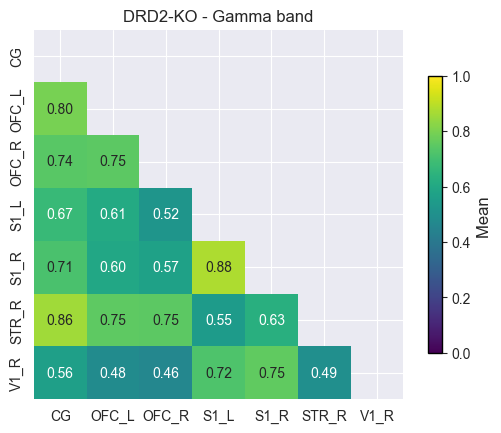

In [20]:
generate_con_heatmap(coh_movement[coh_movement['genotype'] == "DRD2-KO"], 'Delta', fig_title='DRD2-KO - Gamma band', cmap='flare')

Now, let's create a function that allows the creation of a grid that holds a subplot per frequency band and genotype.

In [235]:
def generate_grid_plot(data, method, behaviour, cmap='flare'):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    freq_band_names = freq_bands.keys()
    genotypes = movement_epochs.metadata['genotype'].unique()
    
    # loop through genotypes
    for i, genotype in enumerate(genotypes):
        genotype_data = data[data['genotype'] == genotype]
        # make a subplot for every band of each genotype
        for j, band in enumerate(freq_band_names):
            generate_con_heatmap(genotype_data, band, cmap=cmap, fig_title=f'{genotype} - {band} Band', method=method, ax=ax[i, j])
    
    plt.suptitle(f"Behaviour: {behaviour}")
    plt.tight_layout()
    save_figure(os.path.join(plot_folder, f"connectivity/{method}_grid_{behaviour}.pdf"))

In [236]:
generate_grid_plot(coh_movement, 'coh', "Movement")
generate_grid_plot(coh_non_movement, 'coh', "Non-movement")

### Phase Lag Index (PLI)

* For PLI, means that signal leads and lags signal equally often, while a value greater than means that there is an imbalance in the likelihood for signal to be leading or lagging. A value of means that signal only leads or only lags signal.
*
* For wPLI, means that the total weight (not the quantity) of all leading relationships equals the total weight of lagging relationships, while a value greater than means that there is an imbalance between these weights. A value of, just as in PLI, means that signal only leads or only lags signal.
*
* With dPLI, we gain the ability to distinguish whether signal is leading or lagging signal, complementing the information provided by PLI or wPLI. A value of  means that signal leads and lags signal equally often. A value in the range means that signal leads signal  more often than it lags, with a value of meaning that signal always leads signal. A value in the range means that signal lags signal more often than it leads, with a value of meaning that signal always lags signal. The PLI can actually be extracted from the dPLI by the relationship, but this relationship is not invertible (dPLI can not be estimated from the PLI).

#### Regular PLI

In [237]:
pli_movement = connectivity_df(movement_epochs, "pli")
pli_non_movement = connectivity_df(non_movement_epochs, "pli")

In [238]:
generate_grid_plot(pli_movement, 'pli', "Movement")
generate_grid_plot(pli_non_movement, 'pli', "Non-movement")

#### Directed PLI (DPLI)

In [239]:
dpli_movement = connectivity_df(movement_epochs, "dpli")
dpli_non_movement = connectivity_df(non_movement_epochs, "dpli")

In [240]:
generate_grid_plot(dpli_movement, 'dpli', "Movement")
generate_grid_plot(dpli_non_movement, 'dpli', "Non-movement")

#### Weighted PLI (WPLI)

In [241]:
wpli_movement = connectivity_df(movement_epochs, "wpli")
wpli_non_movement = connectivity_df(non_movement_epochs, "wpli")

In [242]:
generate_grid_plot(wpli_movement, 'wpli', "Movement")
generate_grid_plot(wpli_non_movement, 'wpli', "Non-movement")

#### WPLI2 debiased

In [243]:
wpli2_movement = connectivity_df(movement_epochs, "wpli2_debiased")
wpli2_non_movement = connectivity_df(non_movement_epochs, "wpli2_debiased")

In [244]:
generate_grid_plot(wpli2_movement, 'wpli2_debiased', "Movement")
generate_grid_plot(wpli2_non_movement, 'wpli2_debiased', "Non-movement")

### Barplotting

Let's define a general function that takes our pre-generated dataframes holding the connectivity measure data, and generates a barplot per unique channel combination (hue on genotype).

In [256]:
def generate_barplots(data, method, behaviour):
    combinations = data['node1'] + '-' + data['node2']
    unique_combinations = combinations.unique()
    
    for combination in unique_combinations:
        # subset the data
        chan1, chan2 = combination.split('-')
        data_subset = data[(data['node1'] == chan1) & (data['node2'] == chan2)]
        
        sns.barplot(data_subset, x="band", y="con", hue="genotype", palette=['darkorange', 'dodgerblue'])
        plt.title(f"Connectivity in the two genotypes: {chan1} <-> {chan2}\nMeasure: {method.upper()}, Behaviour: {behaviour}")
        plt.xlabel("Frequency band")
        plt.ylabel(f"Connectivity ({method.upper()})")
        save_figure(os.path.join(plot_folder, f"connectivity/barplots/{method}/{chan1}_{chan2}_{behaviour}.png"))
        plt.close()

Let's generate the figures for all data

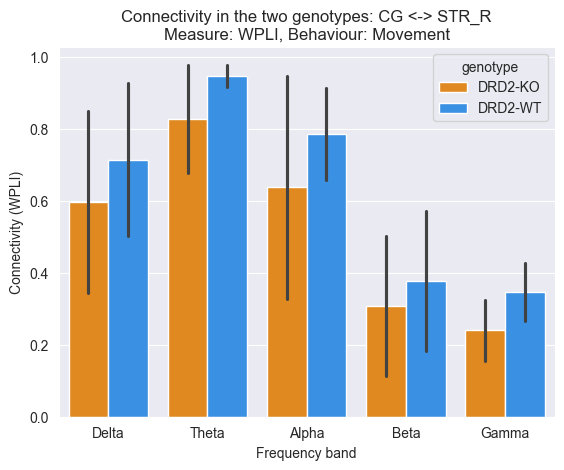

In [255]:
generate_barplots(wpli_movement, "wpli", "Movement")
generate_barplots(wpli_non_movement, "wpli", "Non-movement")

In [247]:
generate_barplots(coh_movement, "coh", "Movement")
generate_barplots(coh_non_movement, "coh", "Non-movement")

In [248]:
generate_barplots(pli_movement, "pli", "Movement")
generate_barplots(pli_non_movement, "pli", "Non-movement")

In [249]:
generate_barplots(dpli_movement, "dpli", "Movement")
generate_barplots(dpli_non_movement, "dpli", "Non-movement")

Let's create figures where the WT and KO movement is compared to the non-movement

In [250]:
def generate_barplots_mov_vs_non_mov(method, movement_data, non_movement_data, genotype):
    # combine the data of both behaviours
    ss1 = movement_data[movement_data['genotype'] == genotype]
    ss2 = non_movement_data[non_movement_data['genotype'] == genotype]
    ss1["movement"] = 1
    ss2["movement"] = 0
    concatted = pd.concat([ss1, ss2])
    
    combinations = concatted['node1'] + '-' + concatted['node2']
    unique_combinations = combinations.unique()
    
    for combination in unique_combinations:
        # subset the data
        chan1, chan2 = combination.split('-')
        data_subset = concatted[(concatted['node1'] == chan1) & (concatted['node2'] == chan2)]
        
        sns.barplot(data_subset, x="band", y="con", hue="movement")
        plt.title(f"DRD2-WT: Connectivity of {chan1} and {chan2} ({method.upper()}) in\n movement and non-movement epochs", fontweight='bold')
        plt.xlabel("Frequency band")
        plt.ylabel(f"Connectivity ({method.upper()})")
        plt.plot()
        save_figure(os.path.join(plot_folder, f"connectivity/barplots/mov_vs_non_mov/{genotype}/{method.upper()}/{chan1}_{chan2}.png"))

Let's run it for the WT subjects

In [251]:
generate_barplots_mov_vs_non_mov(method='coh', movement_data=coh_movement, non_movement_data=coh_non_movement, genotype="DRD2-WT")
generate_barplots_mov_vs_non_mov(method='pli', movement_data=pli_movement, non_movement_data=pli_non_movement, genotype="DRD2-WT")
generate_barplots_mov_vs_non_mov(method='dpli', movement_data=dpli_movement, non_movement_data=dpli_non_movement, genotype="DRD2-WT")
generate_barplots_mov_vs_non_mov(method='wpli', movement_data=wpli_movement, non_movement_data=wpli_non_movement, genotype="DRD2-WT")

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_1019/2395336691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss1["movement"] = 1
/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_1019/2395336691.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss2["movement"] = 0
/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_1019/2395336691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

And for the KO subjects

In [252]:
generate_barplots_mov_vs_non_mov(method='coh', movement_data=coh_movement, non_movement_data=coh_non_movement, genotype="DRD2-KO")
generate_barplots_mov_vs_non_mov(method='pli', movement_data=pli_movement, non_movement_data=pli_non_movement, genotype="DRD2-KO")
generate_barplots_mov_vs_non_mov(method='dpli', movement_data=dpli_movement, non_movement_data=dpli_non_movement, genotype="DRD2-KO")
generate_barplots_mov_vs_non_mov(method='wpli', movement_data=wpli_movement, non_movement_data=wpli_non_movement, genotype="DRD2-KO")

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_1019/2395336691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss1["movement"] = 1
/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_1019/2395336691.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss2["movement"] = 0
/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_1019/2395336691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val